<a href="https://colab.research.google.com/github/AleCongi/Esame-ICON-/blob/main/FuzzyReady.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ingegneria della Conoscenza
Università degli studi di Bari "Aldo Moro", Dipartimento di Informatica.

Il seguente notebook è stato elaborato degli studenti:


*   Congedo Alessandro (mat. 677315)
*   Romano Andrea (mat. XXXXXX)

Il progetto che presentiamo è un esempio di come l'IA possa essere utilizzata per classificare eventi in base a descrizioni e categorie.

---



L'obiettivo di questo studio è quello di sviluppare un sistema di apprendimento automatico che sia in grado di rappresentare la conoscenza sia a basso livello che ad alto livello, garantendo una gestione d'incertezza.

Il progetto è stato condotto nell'ottica di arricchire il precedente lavoro dei [**BroUsers**](https://www.instagram.com/bro__users) chiamato [**OneNight**](https://t.me/wannight_bot), un **bot Telegram** che raccoglie informazioni sugli eventi in una determinata zona geografica.

---
L'esigenza di una filtrazione ulteriore degli eventi mediante delle categorie prestabilite si configura come una nuova espansione del progetto.

La passione che abbiamo per il nostro lavoro, sia quello sviluppato in passato che quello presentato, ci ha spinto a esplorare nuove soluzioni e a sviluppare un sistema che possa fornire un contributo significativo alla comunità.

**Indice delle sezioni:**


*   **A**: *CARICAMENTO E FIX DEL DATASET*
  * **A1**: *PLOT DEL DATASET*
*   **B**: *PREPROCESS DELLE DESCRIZIONI*
  * **B1**: *FUNZIONI PREPROCESSING*
  * **B2**: *PREPROCESSING*
  * **B3**: *TOKENIZATION, SEQUENCING & PADDING*
  * **B4**: *RAPPRESENTAZIONE DEL TESTO A BASSO LIVELLO*
      * **B4.1** *ALTERNATIVA EMBEDDINGS VIA WORLD2VEC*
      * **B4.2** *ALTERNATIVA FEATURE EXTRACTION VIA RETE NEURALE*
      * **B4.3** *ALTERNATIVA VECTORIZATION VIA TERM FREQUENCY - INVERSE DOCUMENT FREQUENCY*
*   **C**: *CLASSIFICAZIONE*
*   **D**: *RETE NEURALE*
*   **E**: *LOGICHE FUZZY*
*   **F**: *RAPPRESENTAZIONE DELLA CONOSCENZA*
  * **F1**: *ONTOLOGIA: WORDNET*
  * **F2**: *RETE SEMANTICA*



In [98]:
!pip install nltk
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [99]:
import numpy as np
from numpy.ma.core import outer
import pandas as pd
import seaborn as sns
from re import sub as sub
from sys import exit as exit
import matplotlib.pyplot as plt
import string

import networkx as nx

from sklearn.metrics.pairwise import cosine_similarity

import sys

from wordcloud import WordCloud

from sklearn.metrics import pairwise_distances


from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download as dl
from nltk import word_tokenize as tkn


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.naive_bayes import GaussianNB,BernoulliNB,CategoricalNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


#Metrics
from sklearn.metrics import accuracy_score, average_precision_score, f1_score, hamming_loss, label_ranking_average_precision_score, precision_recall_curve, recall_score, classification_report, r2_score

#Multilable
from skmultilearn.problem_transform import BinaryRelevance, LabelPowerset
from skmultilearn.ensemble import RakelD, RakelO, LabelSpacePartitioningClassifier
from skmultilearn.adapt import MLkNN

dl('wordnet')
dl('omw-1.4')
dl('punkt')
dl('stopwords')

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##**A**: *CARICAMENTO E FIX DEL DATASET*

In [100]:
tot=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/eventsFixed.csv')

tot.head(10)

,id,fun,food,culture,isOpen,isMusic,text
0,1000187186721956,1,0,1,-1,0,Martedi 05 gennaio super tombolata al Barfly!\...
1,1007051849450711,0,0,0,-1,0,NaN
2,100731190460200,0,0,1,-1,1,"Ingresso free senza obbligo di consumazione,se..."
3,1014507045355357,0,0,0,-1,1,"Giovedi 8 Marzo, Napulitanata ""celebra la donn..."
4,1015563648832823,0,0,1,-1,1,yn e lieta di presentare\n\nNapoolyn x Resilie...
5,1021806692027608,0,0,0,-1,1,Serata live \nVENERDI' 18 MARZO \nUn piacevole...
6,1023358881203820,1,0,0,-1,0,Quest'anno in occasione di san Valentino il ri...
7,1026307021482635,1,0,1,-1,0,Menu adulti 30.00\nMenu bambini 15.00
8,1026761354178792,1,0,1,-1,0,Menu adulti 30.00\nMenu bambini 15.00
9,103006560538403,0,1,1,-1,1,La 1 Esposizione dei disegni di DIPSTER accomp...


In [101]:
tot.count()

id         7688
fun        7688
food       7688
culture    7688
isOpen     7688
isMusic    7688
text       7170
dtype: int64

È chiaro che ci siano dei testi nulli. È possibile che siano eventi senza descrizione. Me ne accerto:

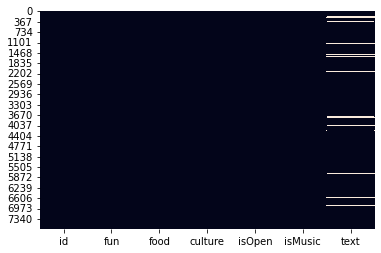

In [102]:
sns.heatmap(tot.isna(), cbar=False)

Sapendo che "id" è la nostra colonna primaria, controllo che il numero di valori unici nella colonna primaria sia uguale al numero di righe. Questo mi permette di accertarmi di non avere la stessa riga per più di una volta nel mio dataset.

In [103]:
tot['id'].nunique() == len(tot['id'])

False

In [104]:
tot = tot.drop_duplicates(subset="id", keep='last')
tot = tot.drop_duplicates(subset="text", keep='last')

for index, row in tot.iterrows():  
  try:
    trashId = row['id']
    trash = row['text'].lower()
  except AttributeError as ae:
    tot.drop(tot[tot['id'] == trashId].index, inplace=True)


In [105]:
tot['id'].nunique() == len(tot['id'])

True

In [106]:
tot.drop('isOpen',inplace=True,axis=1)


,id,fun,food,culture,isMusic,text
0,1000187186721956,1,0,1,0,Martedi 05 gennaio super tombolata al Barfly!\...
1,100731190460200,0,0,1,1,"Ingresso free senza obbligo di consumazione,se..."
2,1014507045355357,0,0,0,1,"Giovedi 8 Marzo, Napulitanata ""celebra la donn..."
3,1015563648832823,0,0,1,1,yn e lieta di presentare\n\nNapoolyn x Resilie...
4,1021806692027608,0,0,0,1,Serata live \nVENERDI' 18 MARZO \nUn piacevole...
...,...,...,...,...,...,...
6322,996956944037551,0,0,0,1,Hot Club Roma Trio\n\nMoreno Viglione chitarra...
6323,997255064998935,0,1,0,0,"Presentazione del libro:\n ""Tasmania"" (Einaudi..."
6324,997824980996408,0,1,1,1,In occasione delle GIORNATE EUROPEE DEL PATRIM...
6325,998364400508276,0,0,1,0,Vieni a Danzare gratuitamente per un giorno co...


In [149]:
tot=tot.reset_index(drop=True)

In [107]:
tot.count()

id         6327
fun        6327
food       6327
culture    6327
isMusic    6327
text       6327
dtype: int64

In [108]:
print(tot['text'][200])
print(tot['food'][200])
print(tot['fun'][200])
print(tot['isMusic'][200])
print(tot['culture'][200])

GIOVEDi 26 MAGGIO 2016 // 'NAPERITIVO IN OFFICINA...
Una serata speciale al borgo marinaro con mini fish burger, prosecco e dj set live. Ti aspettiamo!
INFO t. 081 19353543
0
1
0
1


###**A1**: *PLOT DEL DATASET*

Ecco i primi elementi del dataset.

In [109]:
tot.head()

,id,fun,food,culture,isMusic,text
0,1000187186721956,1,0,1,0,Martedi 05 gennaio super tombolata al Barfly!\...
2,100731190460200,0,0,1,1,"Ingresso free senza obbligo di consumazione,se..."
3,1014507045355357,0,0,0,1,"Giovedi 8 Marzo, Napulitanata ""celebra la donn..."
4,1015563648832823,0,0,1,1,yn e lieta di presentare\n\nNapoolyn x Resilie...
5,1021806692027608,0,0,0,1,Serata live \nVENERDI' 18 MARZO \nUn piacevole...


In [110]:
tot.dtypes

id          int64
fun         int64
food        int64
culture     int64
isMusic     int64
text       object
dtype: object

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


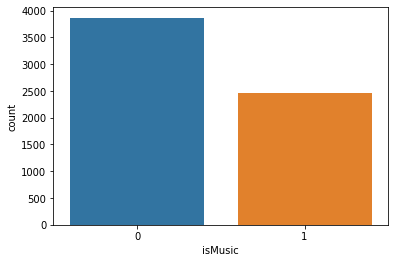

In [111]:
sns.countplot(tot['isMusic'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


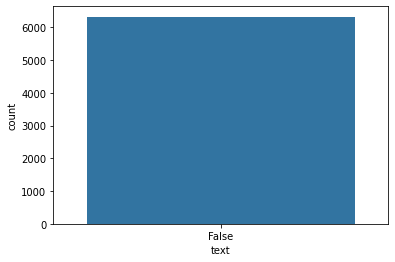

In [112]:
sns.countplot((tot["text"] == None))

##**B**: *PREPROCESS DELLE DESCRIZIONI*

###**B1**: *FUNZIONI PREPROCESSING*

In [113]:
def remove_numbers(input_string):
    # Crea una tabella di traduzione che mappa tutti i numeri a None
    translate_table = input_string.maketrans("", "", string.digits)
    # Utilizza la tabella di traduzione per rimuovere tutti i numeri
    return input_string.translate(translate_table)

def remove_punctuation(input_string):
    for char in string.punctuation:
          input_string = input_string.replace(char, " ")
    return input_string

def preProcessDescription(description,tokenizer,stopwordsTotali,maxSeqLen):
  words = remove_punctuation(remove_numbers(description.lower())).split()

  parole_filtrate = [parola for parola in words if not parola in stopwordsTotali]
 
  descrizione_filtrata = " ".join(parole_filtrate)
  print(descrizione_filtrata)
  # convert the text to a numerical representation
  input_data = tokenizer.texts_to_sequences([descrizione_filtrata])
  input_data = pad_sequences(input_data, maxlen=maxSeqLen,padding='post')
  original_description = ""
  for i, word in enumerate(input_data[0]):
    if word == 1:
      for key, value in tokenizer.word_index.items():
        if value == i :
          original_description += key + " "
  print('Traduzione della sequenza numero in parole: ')
  print(original_description)
  return input_data

###**B2**: *PREPROCESSING*

In [114]:
stp = open("/content/drive/MyDrive/Colab Notebooks/stopwordsita.txt", "r")
data = stp.read().split("\n")
stp.close()
stopwordsTotali = stopwords.words('italian') + stopwords.words('english') + data
stopwordsTotali = list(set(stopwordsTotali))

In [115]:
descrizioni_filtrate = []
for index, descrizione in tot.iterrows():
  parole = tkn(remove_punctuation(remove_numbers(str(descrizione['text']).lower())))
  parole_filtrate = [parola for parola in parole if not parola in stopwordsTotali]
  descrizione_filtrata = " ".join(parole_filtrate)
  descrizioni_filtrate.append(descrizione_filtrata)

In [116]:
descrizioni_filtrate[0]

'super tombolata barfly tante calze vincere formula panino patatine bibita cartella offriamo consigliata prenotazione'

In [117]:
tot['text'][0]

'Martedi 05 gennaio super tombolata al Barfly!\nTante calze da vincere!!!\nFormula 10 euro panino patatine e bibita e la cartella la offriamo noi!\nConsigliata la prenotazione\n081660023'

In [118]:
corpus = descrizioni_filtrate

In [119]:
type(corpus)

list

In [120]:
print(len(tot['text']) == len(corpus))

True


In [121]:
tot['filtered_desc']=corpus

In [122]:
tot

,id,fun,food,culture,isMusic,text,filtered_desc
0,1000187186721956,1,0,1,0,Martedi 05 gennaio super tombolata al Barfly!\...,super tombolata barfly tante calze vincere for...
2,100731190460200,0,0,1,1,"Ingresso free senza obbligo di consumazione,se...",ingresso free obbligo consumazione serata disc...
3,1014507045355357,0,0,0,1,"Giovedi 8 Marzo, Napulitanata ""celebra la donn...",napulitanata celebra donna serata eccezione ma...
4,1015563648832823,0,0,1,1,yn e lieta di presentare\n\nNapoolyn x Resilie...,yn lieta presentare napoolyn x resilienza reco...
5,1021806692027608,0,0,0,1,Serata live \nVENERDI' 18 MARZO \nUn piacevole...,serata live piacevole ritorno palco biergrube ...
...,...,...,...,...,...,...,...
7683,996956944037551,0,0,0,1,Hot Club Roma Trio\n\nMoreno Viglione chitarra...,hot club trio moreno viglione chitarra solista...
7684,997255064998935,0,1,0,0,"Presentazione del libro:\n ""Tasmania"" (Einaudi...",presentazione libro tasmania einaudi editore p...
7685,997824980996408,0,1,1,1,In occasione delle GIORNATE EUROPEE DEL PATRIM...,occasione giornate europee patrimonio ore muse...
7686,998364400508276,0,0,1,0,Vieni a Danzare gratuitamente per un giorno co...,vieni danzare gratuitamente giorno amici tagga...


###**B3**: *TOKENIZATION, SEQUENCING & PADDING*

In [123]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_NB_WORDS = 30000

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)
seq_lens = [len(s) for s in sequences]

In [124]:
sampleIndex = 1998
print('Sequenza parola numero %s: ' % sampleIndex)
for x in sequences[sampleIndex]:
  print('%d,' % x, end =' ')

Sequenza parola numero 1998: 
1939, 367, 12159, 23666, 1939, 839, 367, 23667, 839, 1473, 19, 1438, 783, 23667, 839, 881, 590, 5658, 416, 2670, 2876, 15954, 431, 1939, 17825, 3889, 1536, 6204, 1671, 187, 109, 5313, 1299, 4716, 204, 23, 8341, 89, 170, 62, 9073, 89, 10234, 917, 963, 5416, 13568, 10492, 611, 1426, 1276, 18041, 1578, 1529, 23668, 12159, 267, 2488, 54, 8341, 971, 4854, 22671, 

In [125]:
print('Traduzione della sequenza numero %d in parole: ' % sampleIndex)
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())
" ".join([index_to_word[i] for i in sequences[sampleIndex]])

Traduzione della sequenza numero 1998 in parole: 


'carbonara day malanghino rilancia carbonara roll day carbo roll regalo ogni ordine almeno carbo roll pesce bianco avocado interno scampi uova quaglia salsa carbonara briciole guanciale croccante ordina app oppure whatsapp delivery take away pranzo cena palese san paolo citta modugno san girolamo santo spirito giovinazzo bitonto elenco completo quartieri paesi citati scrivici privato arriviamo malanghino esperienza giappone casa palese vittorio veneto newopening'

Text(0.5, 1.0, 'Y documenti con X parole')

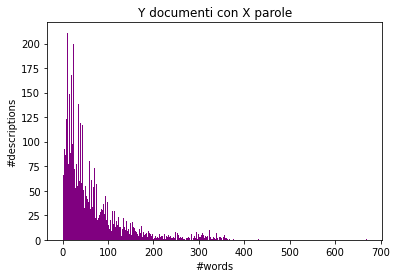

In [126]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(seq_lens, bins=500, color = 'purple')
plt.xlabel('#words')
plt.ylabel('#descriptions')
plt.title('Y documenti con X parole')

In [127]:
media=np.mean(seq_lens)
print("average length: %0.1f" % media)
print("max length: %d" % max(seq_lens))
y = 0
for i in seq_lens:
  if i < media:
    y = y + 1

print("percentuale descrizioni di lunghezza inferiore ad average length: %d%%" % (int(y*100/len(seq_lens))))


average length: 64.3
max length: 670
percentuale descrizioni di lunghezza inferiore ad average length: 66%


La lunghezza media dei testi è di circa 65: eseguo il pad con massima lunghezza 70, valutando che la maggior parte delle descrizioni non supera quel numero di parole.

In [128]:
MAX_SEQUENCE_LENGTH = 70

# pad sequences with 0s
padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

print('Shape of data tensor:', padded.shape)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Shape of data tensor: (6327, 70)
Found 56018 unique tokens.


In [129]:
padded[sampleIndex].shape[0]

70

In [130]:
preProcessDescription('techno rave party festa scuola',tokenizer,stopwordsTotali, MAX_SEQUENCE_LENGTH)

techno rave party festa scuola
Traduzione della sequenza numero in parole: 



array([[1307, 7550,  112,   86,  138,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]], dtype=int32)

###**B4**: *RAPPRESENTAZIONE DEL TESTO A BASSO LIVELLO*

####**B4.1**: *ALTERNATIVA EMBEDDINGS VIA WORLD2VEC*


In [131]:
'''import gensim.downloader as api

# Download the models (1660MB)
word2vec_model300 = api.load('word2vec-google-news-300')'''

"import gensim.downloader as api\n\n# Download the models (1660MB)\nword2vec_model300 = api.load('word2vec-google-news-300')"

In [132]:
'''
x_emb = []
for sentence in padded:
  print('sentence')
  print(sentence)
  sent_emb = [0 for k in range(300)] 
  
  num_tok = 0
  for tok in sentence:
    if tok != 0:
      word=list(word_index.keys())[list(word_index.values()).index(tok)]
      print('word: '+ word)
      try:
          emb = word2vec_model300.wv[word]
          sent_emb = [x + y for x, y in zip(sent_emb, emb)]
          num_tok = num_tok +1
      except:
          pass
  if num_tok != 0:
    final_sent_emb = [x / num_tok for x in sent_emb]         
  x_emb.append(final_sent_emb)
  

x_emb = np.array(x_emb)
with open('/content/drive/MyDrive/Colab Notebooks/embeddings.npy', 'wb') as f:
    np.save(f, x_emb)
'''
with open('/content/drive/MyDrive/Colab Notebooks/embeddings.npy', 'rb') as f:
    x_emb = np.load(f)
print(type(x_emb))
print(len(x_emb))

<class 'numpy.ndarray'>
6327


In [133]:
x_emb.shape

(6327, 300)

In [134]:
print(x_emb[sampleIndex])

[-3.05786133e-02  7.58842699e-02  6.14662170e-02  1.44120419e-01
 -1.97686282e-02  8.10065992e-02 -5.22960316e-03 -4.96363784e-02
 -2.35274344e-03  1.17864435e-01 -9.83539928e-02 -1.38018984e-01
 -1.41777270e-01  2.63907404e-02 -1.08870564e-01  1.45015832e-01
  1.37676239e-01  1.15994540e-01  2.90367820e-02  8.41785778e-02
 -1.09778664e-01 -3.43318130e-02  1.43727389e-01  8.06704434e-02
 -9.10098914e-02 -8.65139094e-02 -1.10806956e-01  9.51815518e-02
 -7.71336411e-02 -2.72553473e-02  1.11357949e-02  7.65165271e-02
  2.58844549e-02 -3.79208651e-02 -9.34795033e-02 -6.82362643e-02
 -6.14663326e-02  4.35656923e-02  9.75188631e-02 -1.69354217e-02
 -2.76641846e-02 -5.28555205e-02  1.05245879e-01  9.82952696e-02
  5.44472897e-03 -1.37826631e-01 -1.16993528e-01 -5.18678607e-02
 -2.40528222e-02  1.39574918e-01 -1.13349683e-01  1.99734775e-01
  9.40972530e-02  5.69162080e-02 -6.25702829e-02  1.85667327e-01
 -1.14800655e-01 -1.09507243e-01  5.17938787e-02 -1.35975231e-01
 -1.49469202e-01  1.08104

####**B4.2**: *ALTERNATIVA FEATURE EXTRACTION VIA RETE NEURALE*

In [135]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten

embedding_size = 100

# Creare la rete neurale feed-forward
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embedding_size, input_length=MAX_SEQUENCE_LENGTH))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Creare la matrice di vettorizzazione delle descrizioni degli eventi
#POTREI PROVARE CON "CORPUS" AL POSTO DI PADDINGS
token_matrix = model.predict(padded)

198/198 [==============================] - 2s 9ms/step


####**B4.3**: *ALTERNATIVA VECTORIZATION VIA TERM FREQUENCY - INVERSE DOCUMENT FREQUENCY*

In [136]:
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(corpus)

##**C**: *CLASSIFICAZIONE*

In [137]:
y = tot[['fun', 'food', 'culture', 'isMusic']]

####Split

In [138]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [139]:
from sklearn.utils import class_weight
weights = class_weight.compute_sample_weight(class_weight="balanced", y=y_train)

In [140]:
weights

array([0.66168141, 0.99593683, 0.85697774, ..., 1.04496771, 0.80683042,
       0.66168141])

In [141]:
from sklearn.decomposition import PCA
pca = PCA (170)

reduced = pca.fit_transform(x_emb)

X_reduced,X_testReduced,y_trainReduced,y_testReduced = train_test_split(reduced,y,test_size=0.25,random_state=42)
reduced.shape

(6327, 170)

####Logistic Regression

In [142]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

test per trasformazione del dataset

In [150]:
target_variables = ["fun", "food", "culture", "isMusic"]

# Fit a logistic regression model for each target variable
models = []
for target in target_variables:
    clf = LogisticRegression(random_state=0)
    clf.fit(X, tot[target])
    models.append(clf)

# Generate probability estimates for each target variable
probabilities = np.zeros((tot.shape[0], len(target_variables)))
for i, clf in enumerate(models):
    probabilities[:, i] = clf.predict_proba(vectorizer.fit_transform(tot["filtered_desc"]))[:, 1]

# Normalize the probabilities so that they sum up to 1 for each sample
probabilities /= probabilities.sum(axis=1, keepdims=True)

# Creare un nuovo dataset con le probabilità
new_df = pd.DataFrame(probabilities, columns=target_variables)

# Aggiungere le descrizioni come nuova colonna
new_df["filtered_desc"] = tot["filtered_desc"]
new_df["text"] = tot["text"]
new_df["id"]=tot["id"].astype(str)
# Salvare il nuovo dataset
#new_df.to_csv("probabilities.csv", index=False)

In [160]:
new_df

,fun,food,culture,isMusic,filtered_desc,text,id
0,0.394694,0.064840,0.430425,0.110041,super tombolata barfly tante calze vincere for...,Martedi 05 gennaio super tombolata al Barfly!\...,1000187186721956
1,0.215571,0.033047,0.390544,0.360837,ingresso free obbligo consumazione serata disc...,"Ingresso free senza obbligo di consumazione,se...",100731190460200
2,0.113385,0.203644,0.281463,0.401508,napulitanata celebra donna serata eccezione ma...,"Giovedi 8 Marzo, Napulitanata ""celebra la donn...",1014507045355357
3,0.032159,0.191603,0.306882,0.469356,yn lieta presentare napoolyn x resilienza reco...,yn e lieta di presentare\n\nNapoolyn x Resilie...,1015563648832823
4,0.102005,0.133685,0.312649,0.451660,serata live piacevole ritorno palco biergrube ...,Serata live \nVENERDI' 18 MARZO \nUn piacevole...,1021806692027608
...,...,...,...,...,...,...,...
6322,0.057426,0.168657,0.269371,0.504545,hot club trio moreno viglione chitarra solista...,Hot Club Roma Trio\n\nMoreno Viglione chitarra...,996956944037551
6323,0.071540,0.623399,0.200155,0.104906,presentazione libro tasmania einaudi editore p...,"Presentazione del libro:\n ""Tasmania"" (Einaudi...",997255064998935
6324,0.047366,0.348093,0.247839,0.356701,occasione giornate europee patrimonio ore muse...,In occasione delle GIORNATE EUROPEE DEL PATRIM...,997824980996408
6325,0.095056,0.238075,0.459258,0.207610,vieni danzare gratuitamente giorno amici tagga...,Vieni a Danzare gratuitamente per un giorno co...,998364400508276


In [161]:
tot

,id,fun,food,culture,isMusic,text,filtered_desc
0,1000187186721956,1,0,1,0,Martedi 05 gennaio super tombolata al Barfly!\...,super tombolata barfly tante calze vincere for...
1,100731190460200,0,0,1,1,"Ingresso free senza obbligo di consumazione,se...",ingresso free obbligo consumazione serata disc...
2,1014507045355357,0,0,0,1,"Giovedi 8 Marzo, Napulitanata ""celebra la donn...",napulitanata celebra donna serata eccezione ma...
3,1015563648832823,0,0,1,1,yn e lieta di presentare\n\nNapoolyn x Resilie...,yn lieta presentare napoolyn x resilienza reco...
4,1021806692027608,0,0,0,1,Serata live \nVENERDI' 18 MARZO \nUn piacevole...,serata live piacevole ritorno palco biergrube ...
...,...,...,...,...,...,...,...
6322,996956944037551,0,0,0,1,Hot Club Roma Trio\n\nMoreno Viglione chitarra...,hot club trio moreno viglione chitarra solista...
6323,997255064998935,0,1,0,0,"Presentazione del libro:\n ""Tasmania"" (Einaudi...",presentazione libro tasmania einaudi editore p...
6324,997824980996408,0,1,1,1,In occasione delle GIORNATE EUROPEE DEL PATRIM...,occasione giornate europee patrimonio ore muse...
6325,998364400508276,0,0,1,0,Vieni a Danzare gratuitamente per un giorno co...,vieni danzare gratuitamente giorno amici tagga...


In [159]:
# Prevedi le etichette per un nuovo evento
new_event = ['Techno rave musica ballo amici alcohol']
X_new = vectorizer.transform(new_event)

y_pred_fun = models[0].predict_proba(X_new)[0][1]
y_pred_food = models[1].predict_proba(X_new)[0][1]
y_pred_culture = models[2].predict_proba(X_new)[0][1]
y_pred_music = models[3].predict_proba(X_new)[0][1]

# Confronta i risultati per evincere la categoria di appartenenza dell'evento
probs = [y_pred_fun, y_pred_food, y_pred_culture, y_pred_music]
pred_class = ['fun', 'food', 'culture', 'music'][np.argmax(probs)]
print(f"The new event belongs to the {pred_class} class with a probability of {np.max(probs):.2f}")

The new event belongs to the culture class with a probability of 0.96


####Da Multi-label a Multi-classe
A questo punto potremmo pensare di rappresentare il nostro Multi-Label problem come un Multi-Class binary classification problem. È utile costruire questo modello come base di confronto per i prossimi modelli: esso tratterà le label come singoli classification problems. Costruiamo il modello di base.

In [147]:
y_test

,fun,food,culture,isMusic
1293,1,1,1,0
7141,0,0,1,1
3846,0,0,1,1
4310,0,1,0,0
5319,0,1,0,0
...,...,...,...,...
3448,0,1,1,0
6162,0,0,0,1
1159,1,0,1,1
6140,1,1,1,1


In [148]:

# Convert Our Multi-Label Prob to Multi-Class
# Binary Classficiation
biRel = BinaryRelevance(KNeighborsClassifier())
biRel2 = BinaryRelevance(SVC())
biRelRed = BinaryRelevance(SVC())
rfc= RandomForestClassifier()

'''
BISOGNA PROVARE COMBINAZIONI FRA CLAS E MOD:
CLAS                | MOD
GaussianNB            BinaryRelevance
BernoulliNB           LabelPowerset
CategoricalNB         RakelD
SVC                   RakelO
KNeighborsClassifier  LabelSpacePartitioningClassifier
SGDClassifier         MLkNN
LogisticRegression
'''

rfc.fit(X_train,y_train, sample_weight=weights)
biRel.fit(X_train,y_train)
biRel2.fit(X_train,y_train)
biRelRed.fit(X_reduced, y_trainReduced)

KeyboardInterrupt: ignored

In [ ]:
# Predictions
prediction = biRel.predict(X_test).toarray()
prediction2 = biRel2.predict(X_test).toarray()
predictionRed = biRelRed.predict(X_testReduced).toarray()

In [ ]:
print('accuracy: %0.5f' % accuracy_score(y_test,prediction))
print('loss di hamming: %0.5f' % hamming_loss(y_test,prediction))
print('label ranking average precision: %0.5f' % label_ranking_average_precision_score(y_test,prediction))
sns.heatmap(pd.DataFrame(classification_report(y_test,prediction, zero_division=1, output_dict=True, target_names=['fun ', 'food', 'culture', 'music'])).iloc[:-1, :].T, annot=True, linecolor='purple')

In [ ]:
print('accuracy: %0.5f' % accuracy_score(y_testReduced,predictionRed))
print('loss di hamming: %0.5f' % hamming_loss(y_testReduced,predictionRed))
print('label ranking average precision: %0.5f' % label_ranking_average_precision_score(y_testReduced,predictionRed))
sns.heatmap(pd.DataFrame(classification_report(y_testReduced,predictionRed, zero_division=1, output_dict=True, target_names=['fun ', 'food', 'culture', 'music'])).iloc[:-1, :].T, annot=True, linecolor='purple')

In [ ]:
print('accuracy: %0.5f' % accuracy_score(y_test,prediction2))
print('loss di hamming: %0.5f' % hamming_loss(y_test,prediction2))
print('label ranking average precision: %0.5f' % label_ranking_average_precision_score(y_test,prediction2))
sns.heatmap(pd.DataFrame(classification_report(y_test,prediction2, zero_division=1, output_dict=True, target_names=['fun ', 'food', 'culture', 'music'])).iloc[:-1, :].T, annot=True, linecolor='purple')

##**D**: *RETE NEURALE*

In [ ]:
# mlp for multi-label classification
from numpy import mean
from numpy import std
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot as plt

# get the model
def get_model(n_inputs, n_outputs):
  model = Sequential()
  model.add(Dense(256, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(n_outputs, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
  return model

# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X_train, y_train, X_test, y_test):
  results = list()
  # define evaluation procedure
  cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  model = get_model(X_train.shape[1], y_train.shape[1])
  # fit model
  fit=model.fit(X_train, y_train, verbose=1, epochs=50)
  # make a prediction on the test set
  yhat = model.predict(X_test)
    # calculate accuracy
  acc = accuracy_score(y_test.round(), yhat.round())
  # store result
  print('>%.3f' % acc)
  results.append(acc)
  print(yhat)
  return results,model

# evaluate model
results,model = evaluate_model(X_train, y_train, X_test, y_test)
# summarize performance
print('Accuracy: %.3f (%.3f)' % (mean(results), std(results)))

###Funzione per costruire il modello

In [ ]:
def build_model(modello,mlb_estimator,xtrain,ytrain,xtest,ytest):
    # Create an Instance
    clf = mlb_estimator(modello)
    clf.fit(xtrain,ytrain)
    # Predict
    clf_predictions = clf.predict(xtest)
    # Check For Accuracy
    acc = accuracy_score(ytest,clf_predictions)
    ham = hamming_loss(ytest,clf_predictions)
    result = {"accuracy:":acc,"hamming_score":ham}
    return result

assegnarli categorie dobbiamo trovare dove la semantica dio un evento che poi puo’derivare da più dati che adesso abbiamo trascurato, in manieraa tale da collocare semantica anche tramite un ontologie esterne il nostro evento in una specie di spazio

questo  ci potrebbe servire per rendere la ricerca di un evento il suo essere consigliato qualcosa di più semantica .


non ci sarà nessun evento in cui ci sarà scritto 'qui si beve alcol' però ci stara degustazione di birra.

potrebbe essere collocare dei termini nello spazio e vedere tramite i dati che noi estraiamo in che posto dello spazio il nostro evento si colloca

Caso d’uso:

mettiamo che tu cerchi :’alcol a bari a quest ora’ .

prendo i 

##**E**: *LOGICHE FUZZY*

In [173]:
!pip install scikit-fuzzy
!pip install fuzzywuzzy
from skfuzzy import control as ctrl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 KB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894088 sha256=19332c08e167df8045ea35c5e18881142a7790248c89b1f8099158dff9ac6c47
  Stored in directory: /root/.cache/pip/wheels/2c/04/80/7eefb1a2de7d36aefd06432fab2a1486caf0a0596a7067391a
Successfully built scikit-fuzzy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import skfuzzy as skf

# Caricamento del dataset
df = tot

# Creazione dei sistemi di inferenza fuzzy
fun_ctrl = ctrl.Antecedent(np.arange(0, 11, 1), "fun")
food_ctrl = ctrl.Antecedent(np.arange(0, 11, 1), "food")
culture_ctrl = ctrl.Antecedent(np.arange(0, 11, 1), "culture")
music_ctrl = ctrl.Antecedent(np.arange(0, 11, 1), "music")

# Definizione delle funzioni d'appartenenza fuzzy per ciascuna categoria
fun_ctrl["low"] = fuzz.trimf(fun_ctrl.universe, [0, 0, 5])
fun_ctrl["medium"] = fuzz.trimf(fun_ctrl.universe, [0, 5, 10])
fun_ctrl["high"] = fuzz.trimf(fun_ctrl.universe, [5, 10, 10])

food_ctrl["low"] = fuzz.trimf(food_ctrl.universe, [0, 0, 5])
food_ctrl["medium"] = fuzz.trimf(food_ctrl.universe, [0, 5, 10])
food_ctrl["high"] = fuzz.trimf(food_ctrl.universe, [5, 10, 10])

culture_ctrl["low"] = fuzz.trimf(culture_ctrl.universe, [0, 0, 5])
culture_ctrl["medium"] = fuzz.trimf(culture_ctrl.universe, [0, 5, 10])
culture_ctrl["high"] = fuzz.trimf(culture_ctrl.universe, [5, 10, 10])

music_ctrl["low"] = fuzz.trimf(music_ctrl.universe, [0, 0, 5])
music_ctrl["medium"] = fuzz.trimf(music_ctrl.universe, [0, 5, 10])
music_ctrl["high"] = fuzz.trimf(music_ctrl.universe, [5, 10, 10])

# Creazione del sistema di inferenza fuzzy per la classificazione degli eventi
event_ctrl = ctrl.Consequent(np.arange(0, 11, 1), "event_type")

In [180]:
from fuzzywuzzy import fuzz

# Definisci una soglia di soglia per determinare la percentuale di similitudine tra descrizioni
threshold = 50


# Prendi una descrizione di evento di riferimento
reference_description = new_df.iloc[10]['text']

# Cicla su tutte le righe del dataframe
for index, row in new_df.iterrows():
    
    # Calcola la percentuale di somiglianza tra la descrizione di riferimento e la descrizione corrente
    similarity = fuzz.ratio(reference_description, row['text'])
    
    # Se la somiglianza è superiore alla soglia, stampa un messaggio
    if similarity > threshold:
        print(f"La descrizione \"{row['text'][:10]}...\" è simile alla descrizione di riferimento con una somiglianza del {similarity}%")

La descrizione "
Siamo spi..." è simile alla descrizione di riferimento con una somiglianza del 100%


##**F**: *RAPPRESENTAZIONE DELLA CONOSCENZA*

###**F1**: *ONTOLOGIA: WORDNET*

In [ ]:
from nltk import word_tokenize
dl('averaged_perceptron_tagger')
dl('wordnet')
from nltk import pos_tag


In [ ]:
from operator import pos
def get_syns(description):
  test=[]
  words = word_tokenize(description)
  for every in words:
    if (every not in stopwordsTotali):
      if(wn.synsets(every, lang ='ita') == []):
        
          test.append(wn.synsets(every))
      else:
        
          test.append(wn.synsets(every, lang ='ita'))
      print('parola iniziale: ',every)
      print('synset: ',wn.synsets(every, lang ='ita'))
  lemmatizer = WordNetLemmatizer()
  out =[]
  for each in range(len(test)):
    for q in range(len(test[each])):
      wordToAdd=lemmatizer.lemmatize(test[each][q].name().split('.')[0])
      out.append(wordToAdd)
      if(q==1):
        print(out)
        break
  out=test
  out=list(set(out))
  return out

def reduced_description(description):
    # Tokenize the description
    tokens = word_tokenize(description)
    # Reduce the words to their most common synset
    reduced_description = []
    for token in tokens:
      try:
          synset = wn.synsets(token, lang='ita',pos=wn.NOUN)
         
          
          lemma = max(synset[0].lemmas(), key=lambda x: x.count()).name()
          reduced_description.append(lemma)
      except:
        try:
          synset = wn.synsets(token, lang='ita',pos=wn.VERB)
          lemma = max(synset[0].lemmas(), key=lambda x: x.count()).name()
          reduced_description.append(lemma)
        except:
          try:
            synset = wn.synsets(token, lang='eng',pos=wn.NOUN)
            lemma = max(synset[0].lemmas(), key=lambda x: x.count()).name()
            reduced_description.append(lemma)
          except:
            try:
                synset = wn.synsets(token, lang='eng',pos=wn.VERB)
                lemma = max(synset[0].lemmas(), key=lambda x: x.count()).name()
                reduced_description.append(lemma)
            except:
                
                continue
   
    return list(set(reduced_description))


def predict_closest_clusters(description, km, X_train1, vectorizerTfIdf):
    description=get_syns(description)
    newWords = ''
    for each in description:
      newWords = newWords + ' ' + each
    description=newWords
    # Transform the input description into a tf-idf representation
    input_tfidf = vectorizerTfIdf.transform([description])
    # Calculate the distances between the input and each of the 10 clusters
    cluster_distances = km.transform(input_tfidf).flatten()
    # Get the index of the closest cluster
    closest_cluster_index = np.argmin(cluster_distances)
    print("The closest cluster is cluster", closest_cluster_index)
    terms = vectorizerTfIdf.get_feature_names()
    top_ten_words = [terms[ind] for ind in order_centroids[closest_cluster_index, :5]]
    print("Its top ten words are: {}".format(', '.join(top_ten_words)))
    # Calculate the distances between the input and each sample in X_train1
    sample_distances = pairwise_distances(input_tfidf, X_train1).flatten()
    # Get the indices of the 5 closest samples
    closest_sample_indices = sample_distances.argsort()[:5]
    print("The 5 closest samples in X_train1 are:")
    for i in closest_sample_indices:
        print(i)

In [ ]:
X1 = []
newText=corpus

for description in newText:   
    feature =[]
    features = reduced_description(str(description))
    words = ''
    for each in features:
      words = words + ' ' + each
    X1.append(words)

In [ ]:
inx=7
print(corpus[inx])
print(X1[inx])

In [ ]:
vectorizerTfIdf=TfidfVectorizer()
vectorTfIdf=vectorizerTfIdf.fit_transform(X1)
X_train1, X_test1 = train_test_split(vectorTfIdf, test_size=0.2, random_state=42) 

In [ ]:
number_of_clusters=10
km = KMeans(n_clusters=number_of_clusters)
# Normally people fit the matrix
km.fit(X_train1)

In [ ]:
# But you could fit the idf_df instea
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizerTfIdf.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :5]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

In [ ]:
cluster_labels=km.labels_
len(cluster_labels)

In [ ]:
descrizione='presentazione nuovo libro di narrativa'
predict_closest_clusters(description, km, X_train1,vectorizerTfIdf)

In [ ]:
labels=km.labels_
cluster_labels = np.unique(labels)
cluster_sizes = [(labels == c).sum() for c in cluster_labels]
sizes_idx = np.argsort(cluster_sizes)[::-1][:5]
X1=X1[:5061]
# Plot dei risultati
for i, c in enumerate(cluster_labels[sizes_idx]):
    mask = (labels == c)
    descrizioni_c = np.array(X1)[mask]
    text = " ".join(descrizioni_c)
    
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = swSet, 
                min_font_size = 10).generate(text)

    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)

###**F2**: *RETE SEMANTICA*

In [165]:
!pip install scipy==1.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 MB 12.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


In [166]:
import  scipy.sparse

In [178]:
G = nx.Graph()


# Aggiungi i nodi per ogni categoria (fun, food, culture, music)
G.add_node("fun")
G.add_node("food")
G.add_node("culture")
G.add_node("isMusic")
    
# Aggiungi gli archi tra le categorie per ogni evento
for index, row in new_df.iterrows():
    description = row["text"]
    for header in ["fun", "food", "culture", "isMusic"]:
        if row[header] != 0:
            G.add_edge(header, description, weight=row[header])
'''
pos = nx.spring_layout(G, seed=225)  # Seed for reproducible layout
nx.draw(G, pos, node_color='red', edge_color='gray', with_labels=True)
plt.show()   

'''
'''# Calcola la centralità di grado per ogni nodo
degree_centrality = nx.degree_centrality(G)

# Trova il nodo più centrale in base alla centralità di grado
most_central = max(degree_centrality, key=degree_centrality.get)
print("Il nodo più centrale in base alla centralità di grado è:", most_central)
'''
# Trova il percorso più breve tra due nodi
shortest_path = nx.shortest_path(G, "fun", "isMusic")
print("Il percorso più breve tra 'fun' e 'music' è:", shortest_path)

neighbors = nx.neighbors(G, new_df['text'][10])
for i, neighbor in enumerate(neighbors):
    if i >= 10:
        break
    print("Neighbor {}: {}".format(i + 1, neighbor))
'''
# Calcola la centralità di PageRank per ogni nodo
pagerank = nx.pagerank(G)

# Trova il nodo con la più alta centralità di PageRank
most_important = max(pagerank, key=pagerank.get)
print("Il nodo più importante in base alla centralità di PageRank è:", most_important)
'''

Il percorso più breve tra 'fun' e 'music' è: ['fun', 'Martedi 05 gennaio super tombolata al Barfly!\nTante calze da vincere!!!\nFormula 10 euro panino patatine e bibita e la cartella la offriamo noi!\nConsigliata la prenotazione\n081660023', 'isMusic']
Neighbor 1: fun
Neighbor 2: food
Neighbor 3: culture
Neighbor 4: isMusic


'\n# Calcola la centralità di PageRank per ogni nodo\npagerank = nx.pagerank(G)\n\n# Trova il nodo con la più alta centralità di PageRank\nmost_important = max(pagerank, key=pagerank.get)\nprint("Il nodo più importante in base alla centralità di PageRank è:", most_important)\n'

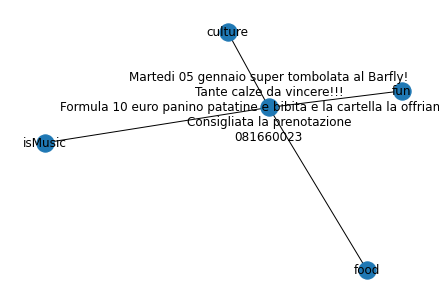

In [171]:
# Find the most important nodes
degree_dict = dict(G.degree(G.nodes()))
sorted_degree = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)
top_nodes = [n for n, d in sorted_degree[:5]] # Plot only the top 50 nodes

# Plot the graph
subgraph = G.subgraph(top_nodes)
nx.draw(subgraph, with_labels=True)
plt.show()

##CNN